In [53]:
# import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score
from torch import nn
from torchvision import transforms as T
import torchvision.models as models

from torch.utils.data import DataLoader

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 1. Load dataloaders

In [55]:
train_ds = torch.load("data/train_dataset.pt")
eval_ds = torch.load("data/eval_dataset.pt")

KeyboardInterrupt: 

In [ ]:
len(train_ds.anchor_data), len(train_ds.anchor_labels), len(eval_ds.anchor_data), len(eval_ds.anchor_labels)

(29997, 29997, 4999, 4999)

In [ ]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
eval_dl = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
loss_history = []
accuracy_history = []

In [56]:
from sklearn.metrics.pairwise import cosine_similarity




def train(model, criterion, optimizer, train_loader, valid_loader, epochs, save_path="models/model"):
    best_val_loss = float('inf')  # Initialize with infinity
    
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)    
    
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0.0
        val_loss = 0
        
        for inputs, labels in train_loader:
            
            input_anchor, input_pos, input_neg = inputs
            # label_anchor, label_pos, label_neg = labels
            
            input_anchor = input_anchor.to(device)
            input_pos = input_pos.to(device)
            input_neg = input_neg.to(device)
            
            emb_anchor = model(input_anchor)
            emb_pos = model(input_pos)
            emb_neg = model(input_neg)
            
            loss = criterion(emb_anchor, emb_pos, emb_neg)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            
        loss_history.append(loss.item())    
        
        scheduler.step(val_loss)
        
        # Validation loop
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        embeddings = []
        targets = []
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                input_anchor, input_pos, input_neg = inputs
                label_anchor, label_pos, label_neg = labels
                
                batch_emb, batch_lab = [], []
                
                input_anchor = input_anchor.to(device)
                input_pos = input_pos.to(device)
                input_neg = input_neg.to(device)
                
                emb_anchor = model(input_anchor)
                emb_pos = model(input_pos)
                emb_neg = model(input_neg)
                
                # embeddings.extend(emb_anchor)
                batch_emb.extend(emb_pos.cpu())
                batch_emb.extend(emb_neg.cpu())
                
                # labels.extend(label_anchor)
                batch_lab.extend(label_pos.cpu().tolist())
                batch_lab.extend(label_neg.cpu().tolist())
                
                embeddings.extend(batch_emb)
                targets.extend(batch_lab)
                
                
                loss = criterion(emb_anchor, emb_pos, emb_neg)
                val_loss += loss.item()
        
        # Average losses
        train_loss /= len(train_loader)
        val_loss /= len(valid_loader)
        
        for i in range(len(embeddings)):
            embeddings[i] = embeddings[i].detach().numpy()
            
        
        embeddings = np.array(embeddings)
        targets = np.array(targets)
        
        # Get cosine similarity for all embeddings
        similarity_matrix = cosine_similarity(embeddings)
        
        # Fill diagonal with inf
        np.fill_diagonal(similarity_matrix, -np.inf)
        
        # Find the index of max sim for each embedding
        most_similar_indices = np.argmax(similarity_matrix, axis=1)
        
        # Extract the labels of the most similar items
        predicted_labels = [targets[i] for i in most_similar_indices]
        
        
        # Get number of correct predictions
        # n_correct = sum(1 for true_label, predicted_label in zip(labels, predicted_labels) if true_label == predicted_label)
        n_correct = sum(1 for true, pred in zip(targets, predicted_labels) if true == pred)
        
        print("Number of correct matches: ", n_correct)

        val_acc = 100 * (n_correct / len(embeddings))

        accuracy_history.append(val_acc)
        
        print(f"Validation accuracy: {val_acc:0.3f}%")
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
        # Save the model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"{save_path}_{epoch}")
            print("Model saved with validation loss:", best_val_loss)


### 2. Get model & train

In [ ]:
import os

# model = models.resnet18(pretrained=False)
model = models.squeezenet1_1(pretrained=True)
print(model)
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
model.fc = torch.nn.Identity()
# if os.path.exists("models/resnet50.pt"):
#     model.load_state_dict(torch.load("models/resnet50.pt"))

model = model.to(device)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sebas\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# import os

# model = models.resnet50(pretrained=True)
# print(model)
# model.fc = torch.nn.Identity()

# if os.path.exists("models/resnet50.pt"):
#     model.load_state_dict(torch.load("models/resnet50.pt"))

# model = model.to(device)


In [57]:
LR = 1e-3

n_epochs = 20

criterion = torch.nn.TripletMarginLoss(margin=1, p=2) 
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [58]:
train_ds.anchor_data[0].shape

(1, 64, 64)

In [59]:
train(model, criterion, optimizer, train_dl, eval_dl, n_epochs, "models/resnet50")

Number of correct matches:  9546
Validation accuracy: 95.479%
Epoch 1/20, Train Loss: 0.2418, Valid Loss: 0.1123
Model saved with validation loss: 0.11228008102625608
Number of correct matches:  9734
Validation accuracy: 97.359%
Epoch 2/20, Train Loss: 0.1146, Valid Loss: 0.0530
Model saved with validation loss: 0.05300542241893709
Number of correct matches:  9732
Validation accuracy: 97.339%
Epoch 3/20, Train Loss: 0.0755, Valid Loss: 0.0533
Number of correct matches:  9824
Validation accuracy: 98.260%
Epoch 4/20, Train Loss: 0.0591, Valid Loss: 0.0307
Model saved with validation loss: 0.030708791594952344
Number of correct matches:  9814
Validation accuracy: 98.160%
Epoch 5/20, Train Loss: 0.0455, Valid Loss: 0.0303
Model saved with validation loss: 0.030251265689730644
Number of correct matches:  9869
Validation accuracy: 98.710%
Epoch 6/20, Train Loss: 0.0372, Valid Loss: 0.0211
Model saved with validation loss: 0.021062478283420207
Number of correct matches:  9868
Validation accur

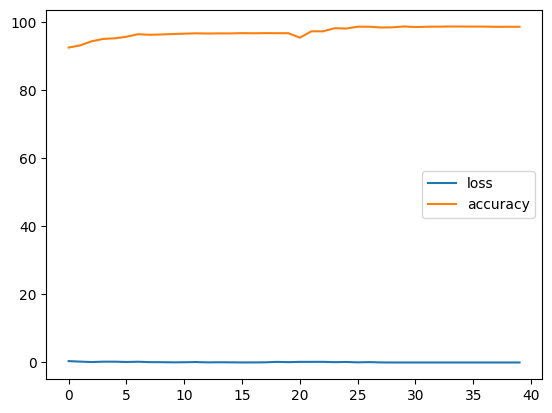

In [60]:
import matplotlib.pyplot as plt


plt.plot(loss_history, label="loss")
plt.plot(accuracy_history, label="accuracy")
plt.legend()

In [ ]:
a = torch.tensor([1,2,3,4,4])
a
b = []
b.extend(a.tolist())
b

[1, 2, 3, 4, 4]

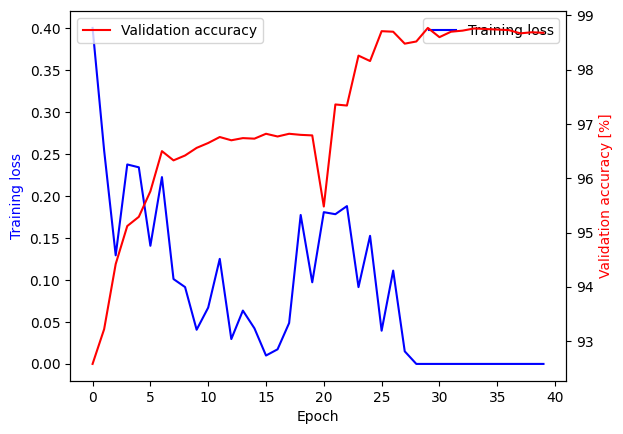

In [67]:
import matplotlib.pyplot as plt

epoch_cutoff = 20

# Create a figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot data on the primary y-axis
ax1.plot(loss_history, color='blue', label='Training loss')
ax1.set_ylabel('Training loss', color='blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot data on the secondary y-axis
ax2.plot(accuracy_history, color='red', label='Validation accuracy')
ax2.set_ylabel('Validation accuracy [%]', color='red')

# Add legend
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.set_xlabel("Epoch")
# Show plot
plt.show()

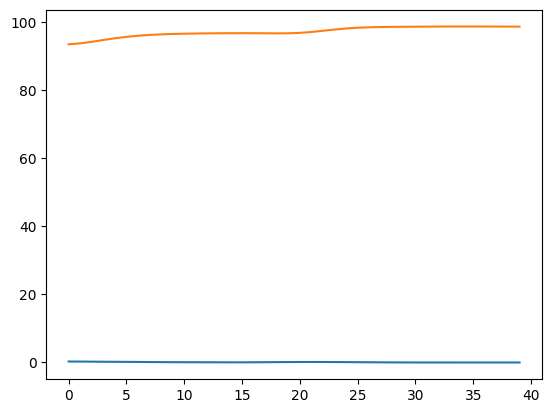

In [65]:
from scipy.ndimage import gaussian_filter1d

_loss_hist = gaussian_filter1d(loss_history, 2)
_acc_h = gaussian_filter1d(accuracy_history, 2)
plt.plot(_loss_hist)
plt.plot(_acc_h)
